# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm

Load the `cardiac_ml_tools` module.

In [3]:
%run cardiac_ml_tools.py

## Load the dataset

In [4]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) 
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\ 
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$


In [21]:
# Example of file pair
case = 213
# ECG plot
row = 3 
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

# Normalize and Convert Data to Numpy Array
def normalize_data(data):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data

n = len(file_pairs)
ecg_data_arr = np.zeros((n, 12, 500))
activation_time_arr = np.zeros((n, 75))
VmData_arr = np.zeros((n, 75, 500))

for i in tqdm(range(n)):
    pECGData = np.load(file_pairs[i][0]) # Fetch Files
    pECGData = get_standard_leads(pECGData) # Convert to 12-lead ECG Data
    cache = pECGData.T # (12, 500)

    # Iterate through each ECG (one for each lead)
    for j in range(12):
        temp = cache[j, :]
        temp = normalize_data(temp) # Normalize 12 Lead ECG Data Row-Wise

        # Patient, ECG Lead, Time (MS)
        ecg_data_arr[i, j, 0:500] = temp
    
    VmData = np.asarray(VmData)
    VmData_arr[i, :, :] = VmData.T

100%|██████████| 16117/16117 [00:17<00:00, 914.99it/s]


<Figure size 1000x700 with 0 Axes>

Activation Time Data:  (16117, 75, 500)
Max:  1.0
Min:  0.0


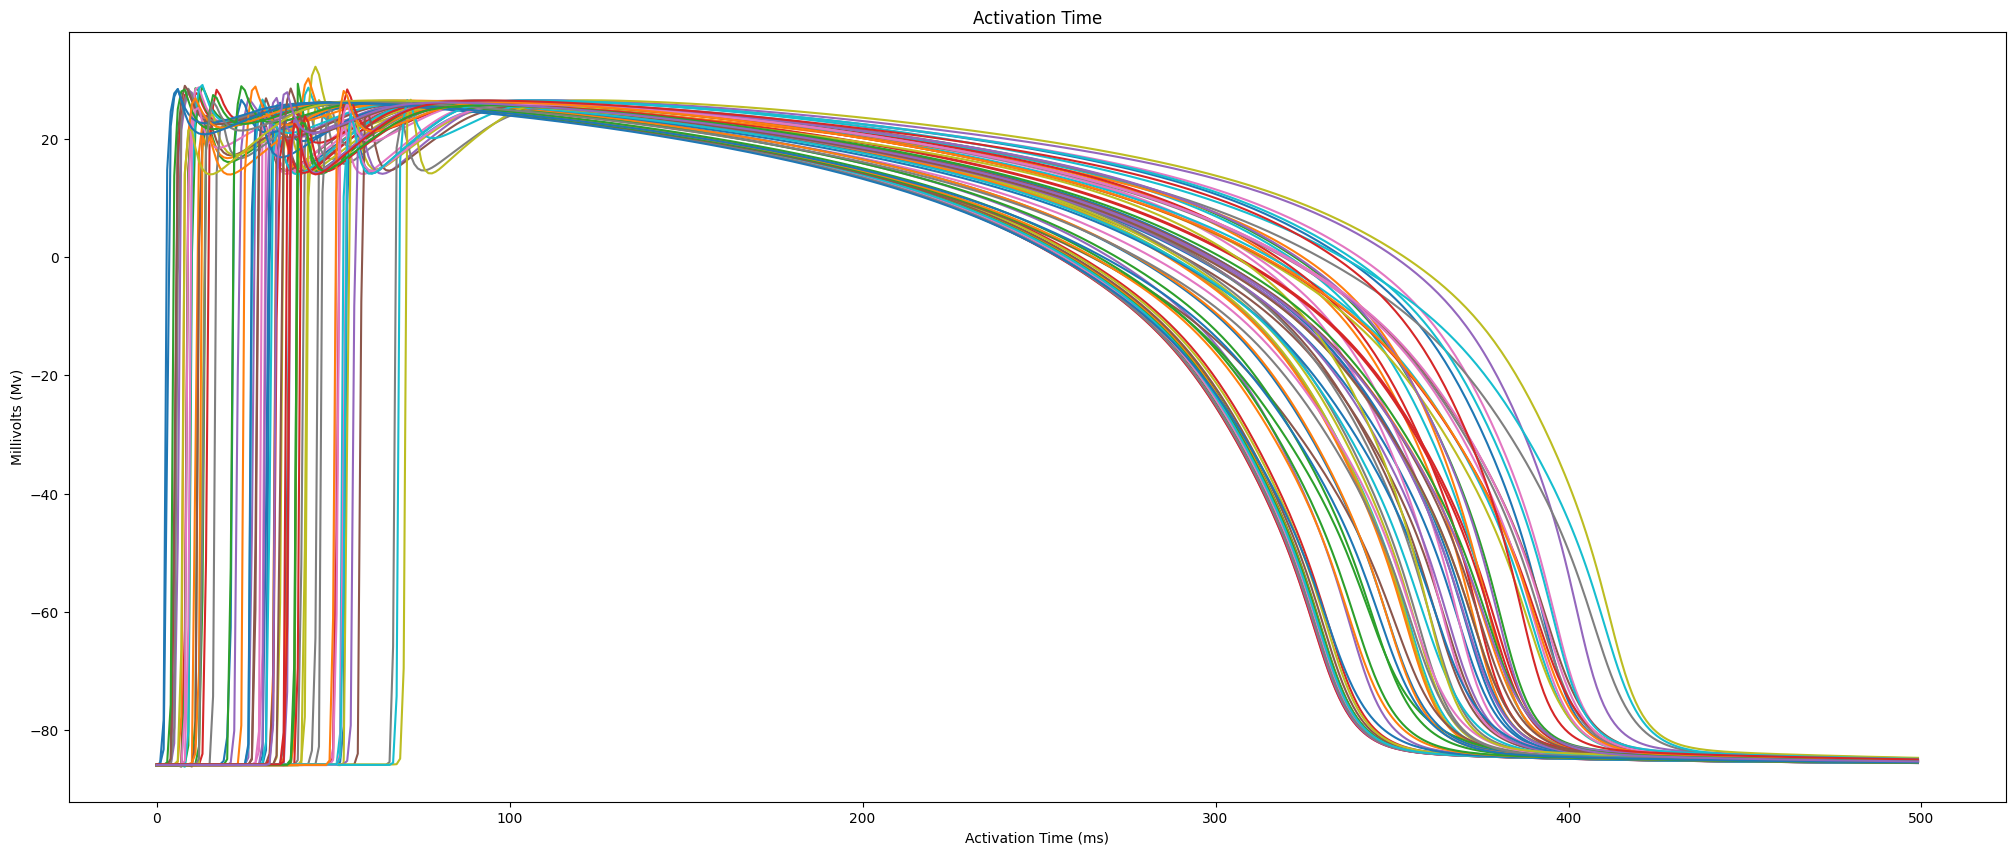

In [167]:
# Print Activation Time Data
print("Activation Time Data: ", VmData_arr.shape)

# Verify Normilization Worked
print("Max: ", np.max(ecg_data_arr))
print("Min: ", np.min(ecg_data_arr))
# Plot VM Data
plt.figure(figsize=(25, 10))
plt.plot(VmData_arr[case, :, :].T)
plt.title("Activation Time")
plt.xlabel("Activation Time (ms)")
plt.ylabel("Millivolts (Mv)")

plt.show()


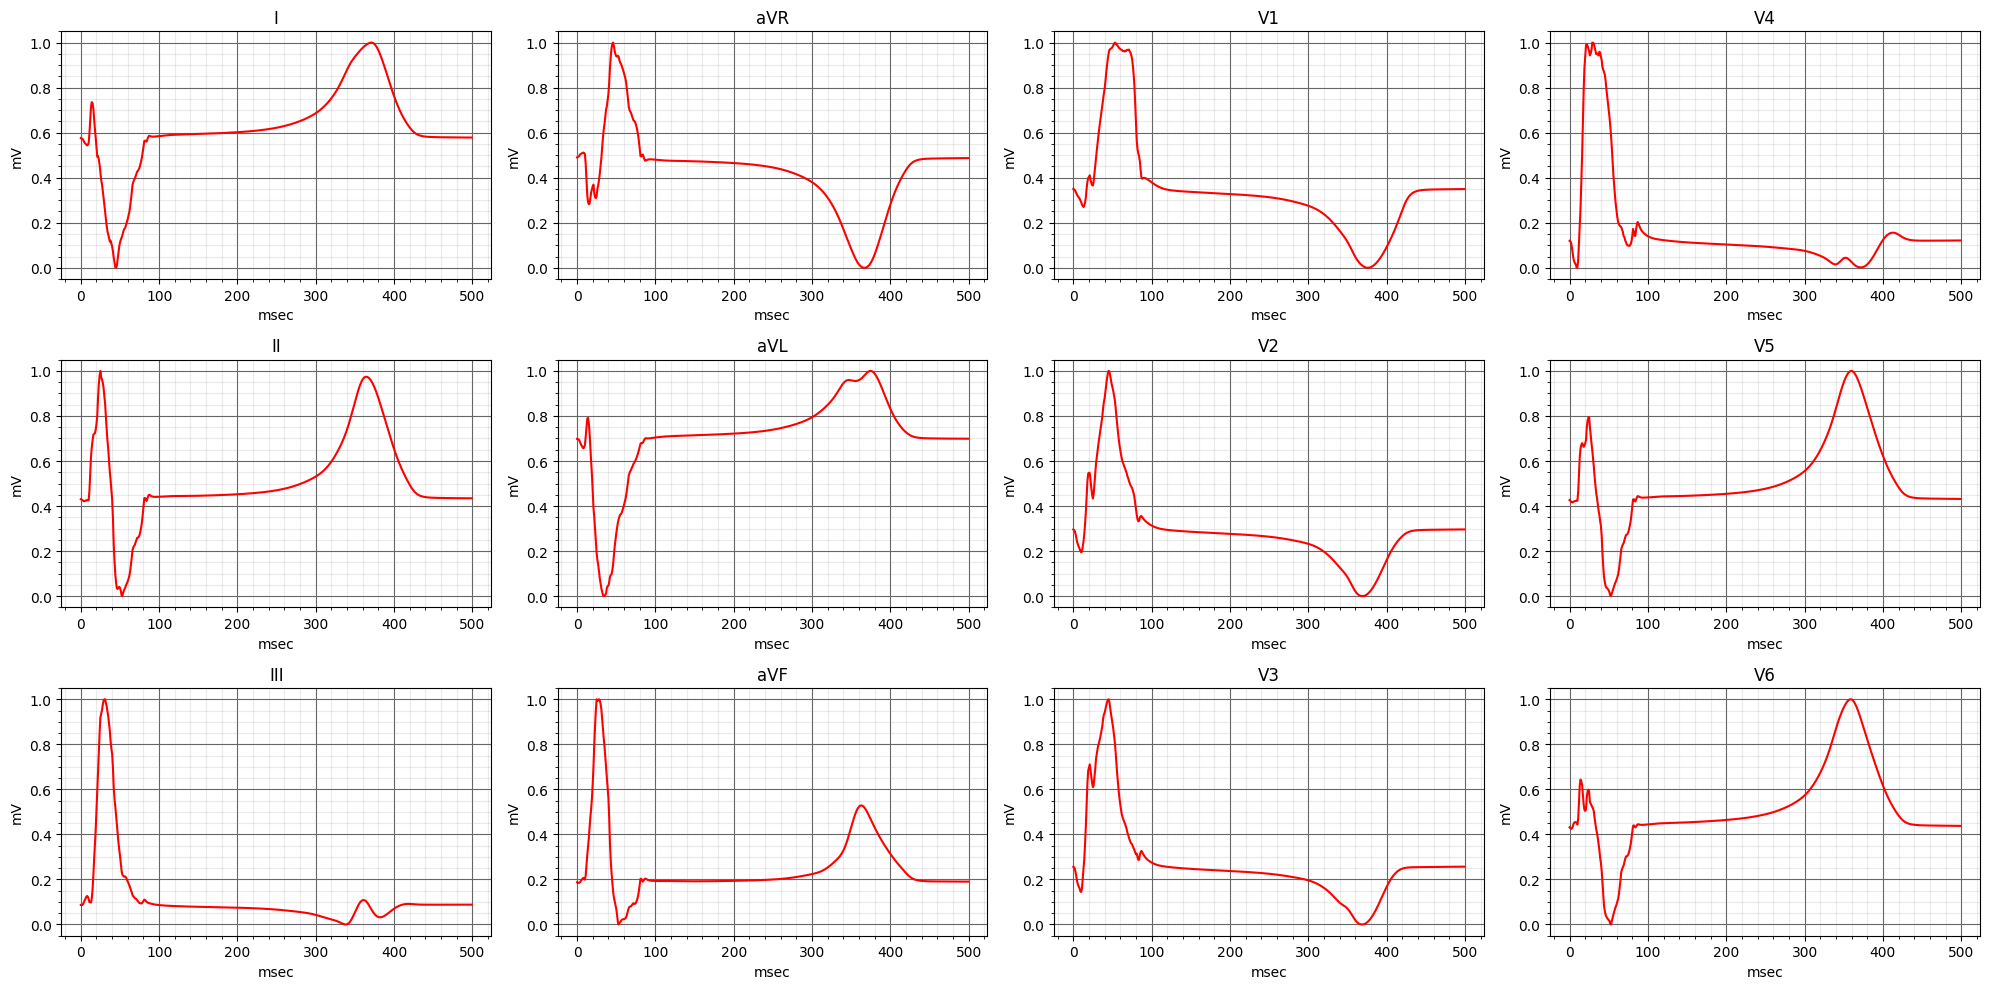

In [23]:
# create a figure with 12 subplots
plt.figure(figsize=(20, 10))
for i in range(12):
    plt.subplot(3, 4, reorder[i + 1])
    plt.plot(ecg_data_arr[case, i, :], color = 'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Getting the transmembrane voltages

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


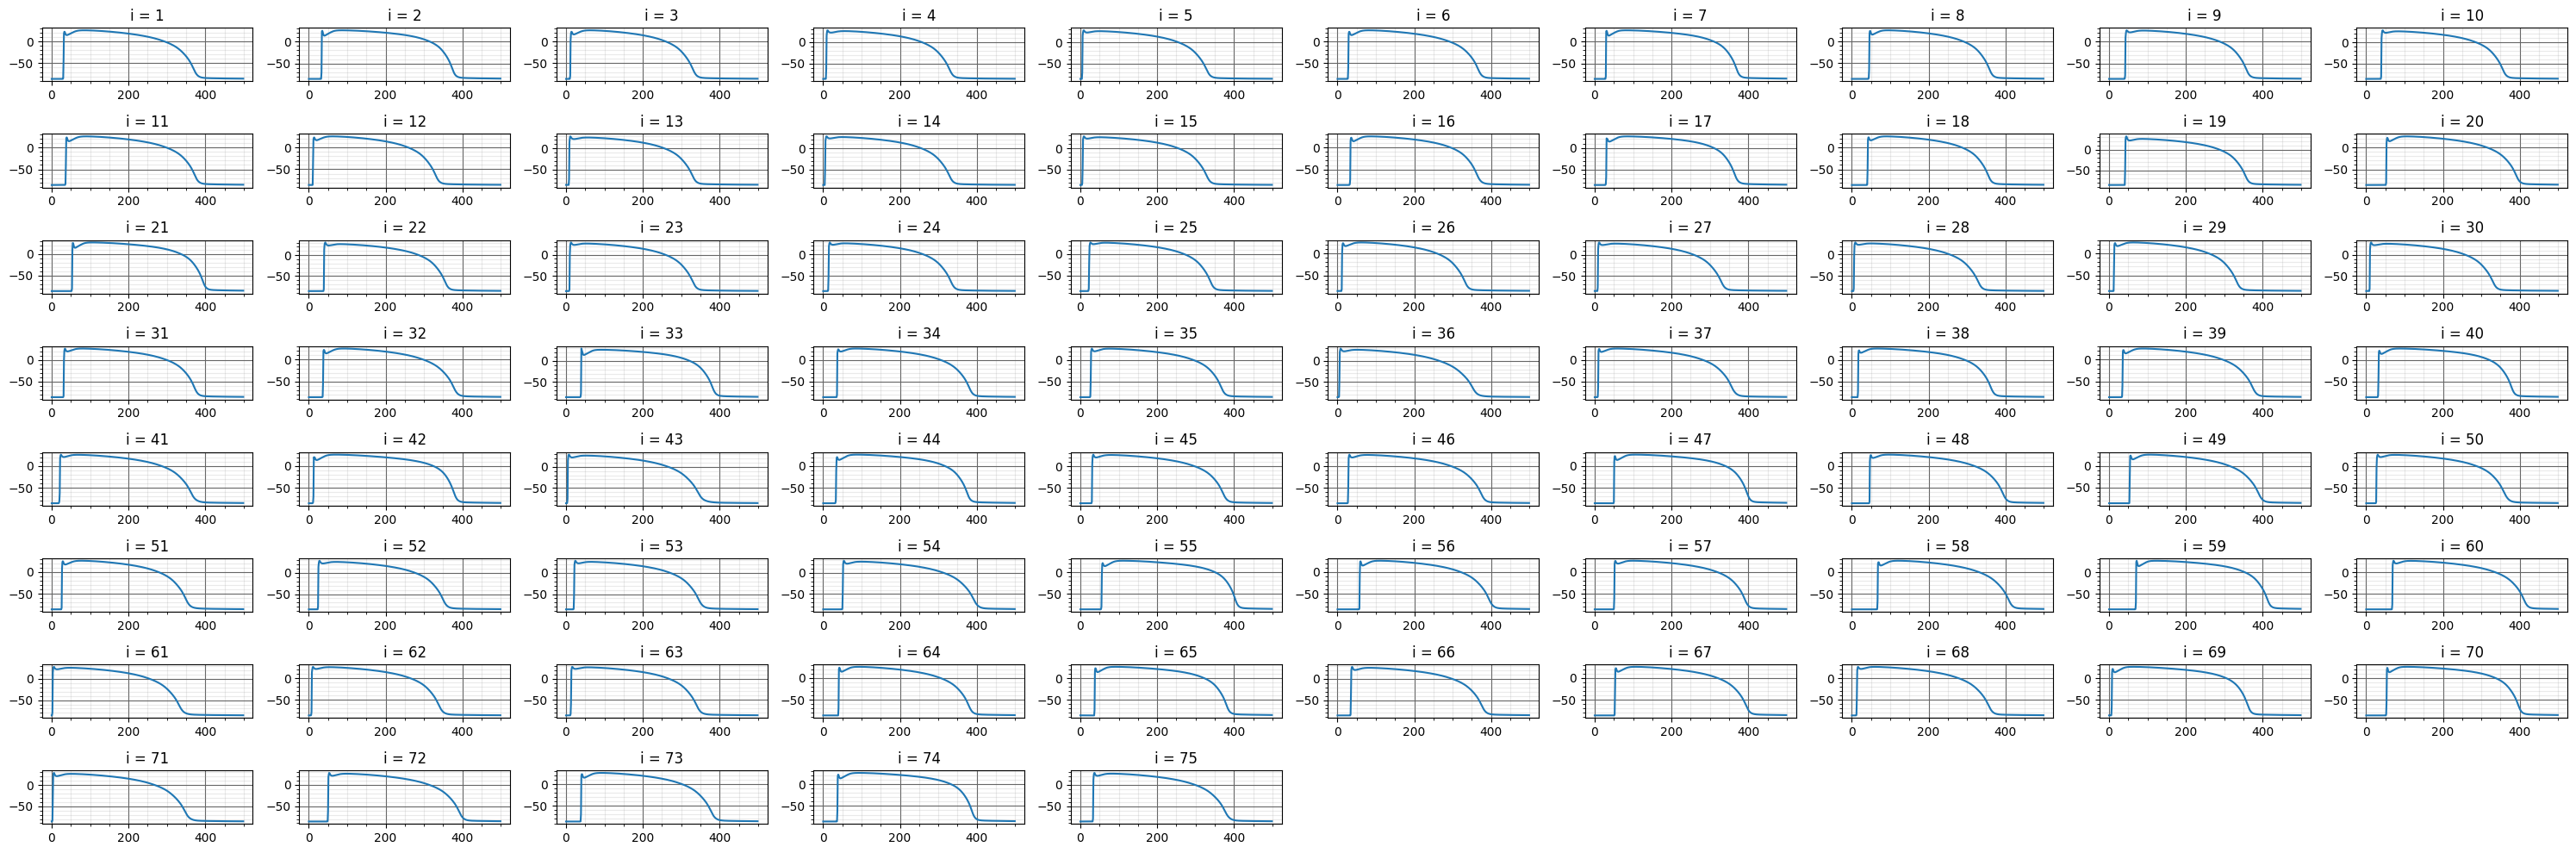

In [24]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(30, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i + 1}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy
(500, 75)


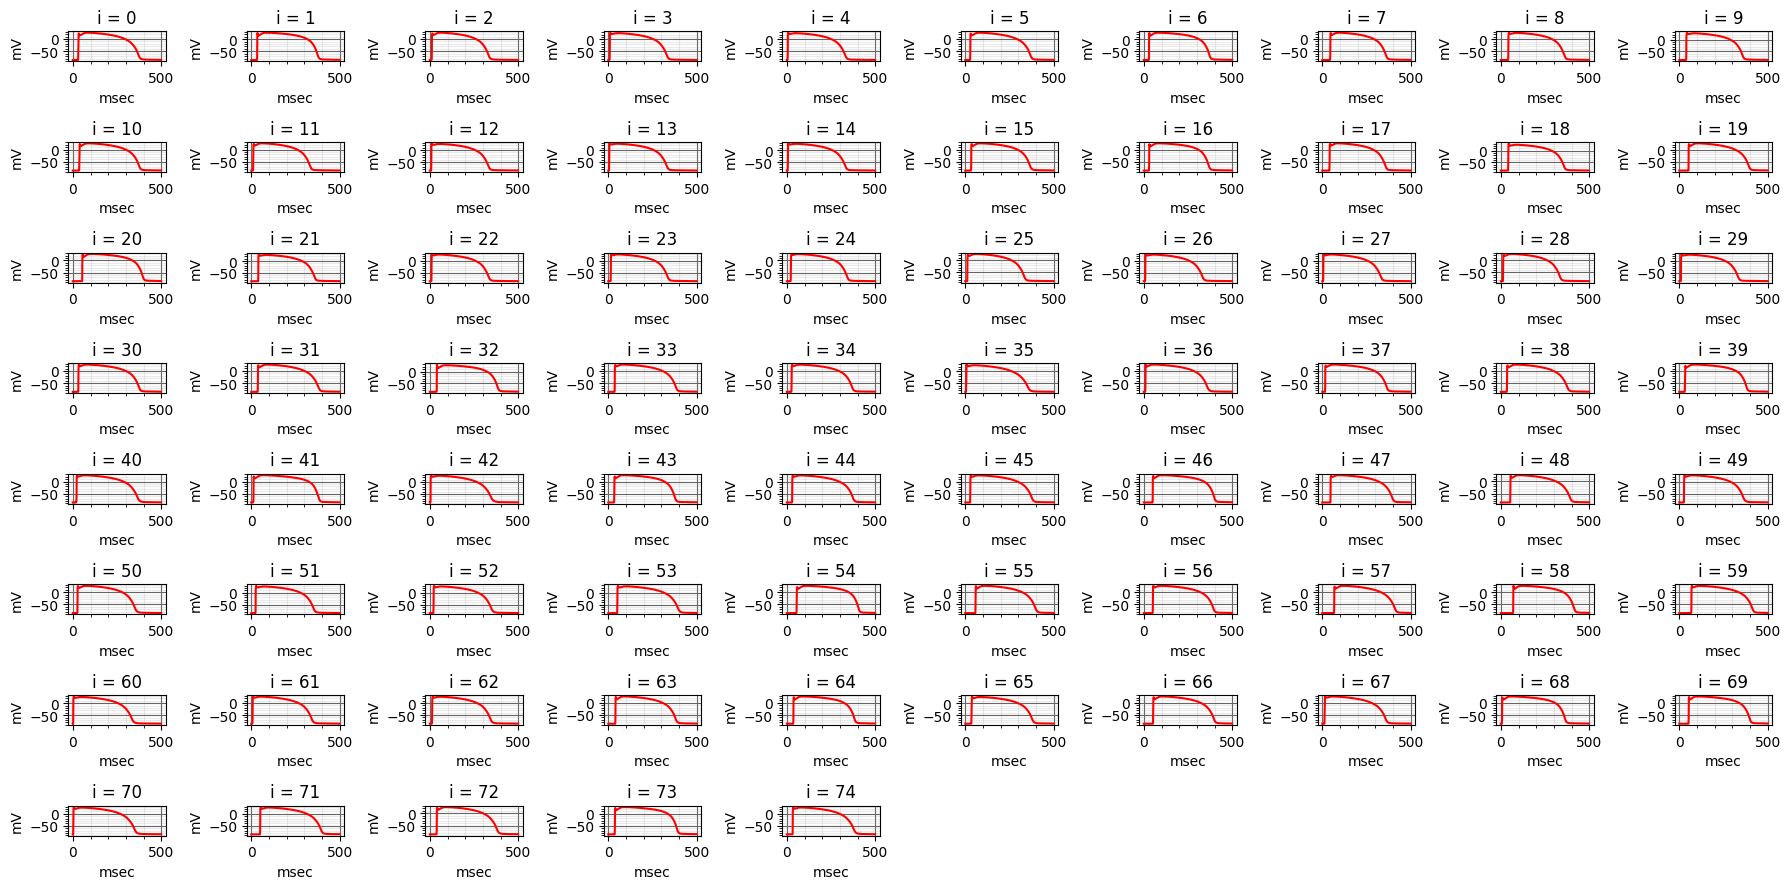

In [25]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
# VmData = VmData_arr[case].T
print(VmData.shape)

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i], color = 'r')
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Task 4: Learning the mapping from the 12-lead ECG to the 75 transmembrane voltages

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy
Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


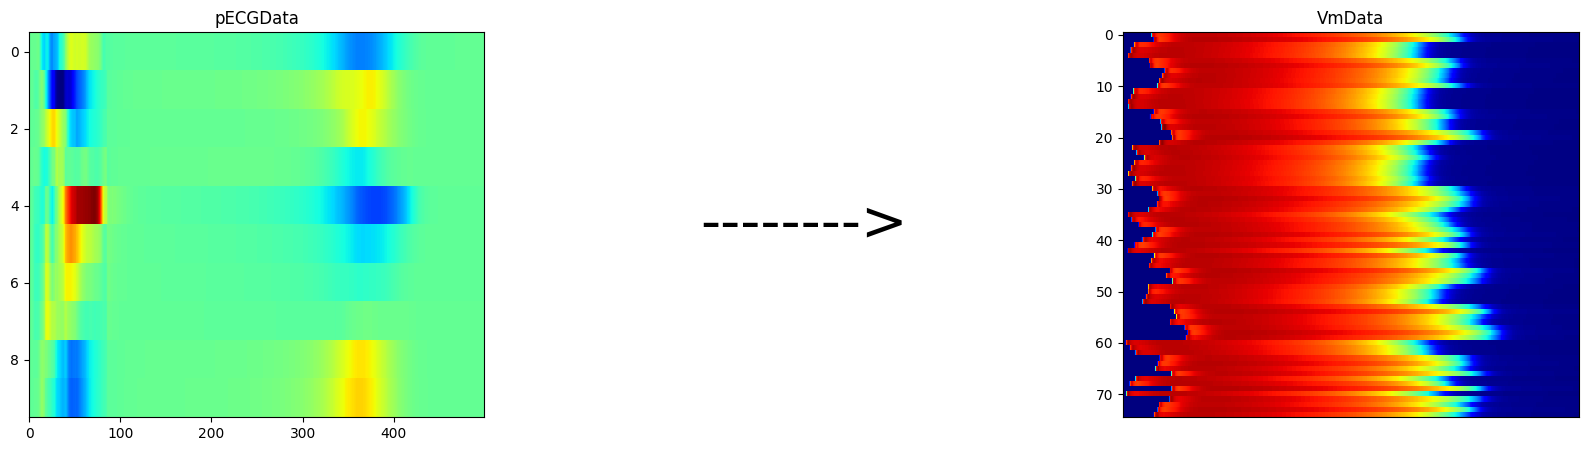

In [26]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('VmData')
plt.show()
plt.close()

In [27]:
print(VmData_arr)

[[[-85.89566344 -85.89176964 -85.89045799 ... -85.29172075 -85.29803944
   -85.3042783 ]
  [-85.79153764 -85.79356227 -85.79639417 ... -85.05781011 -85.06587875
   -85.0738512 ]
  [-85.91698916 -85.91805452 -85.91850012 ... -85.5170188  -85.52092445
   -85.52478444]
  ...
  [-85.8931493  -85.88968885 -85.88859342 ... -85.23691083 -85.24388897
   -85.25077835]
  [-85.79119087 -85.79127885 -85.79178092 ... -84.94123491 -84.95053551
   -84.95972619]
  [-85.92025326 -85.91599583 -85.91441384 ... -85.29259626 -85.29917919
   -85.30567875]]

 [[-85.89566344 -85.89176964 -85.89045799 ... -85.29172075 -85.29803944
   -85.3042783 ]
  [-85.79153764 -85.79356227 -85.79639417 ... -85.05781011 -85.06587875
   -85.0738512 ]
  [-85.91698916 -85.91805452 -85.91850012 ... -85.5170188  -85.52092445
   -85.52478444]
  ...
  [-85.8931493  -85.88968885 -85.88859342 ... -85.23691083 -85.24388897
   -85.25077835]
  [-85.79119087 -85.79127885 -85.79178092 ... -84.94123491 -84.95053551
   -84.95972619]
  [-85.

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

In [107]:
# Import Packages for Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print("ECG DATA ARRAY SHAPE: ", ecg_data_arr.shape)
print("ACTIVATION TIME ARRAY SHAPE: ", VmData_arr.shape)

# Split Data (VmData) into Train and Test
X_train, X_test, y_train, y_test = train_test_split(ecg_data_arr, VmData_arr, test_size=0.2, random_state=42)

ECG DATA ARRAY SHAPE:  (16117, 12, 500)
ACTIVATION TIME ARRAY SHAPE:  (16117, 75, 500)


In [110]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (12893, 12, 500)
y_train:  (12893, 75, 500)
X_test:  (3224, 12, 500)
y_test:  (3224, 75, 500)


In [149]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, SpatialDropout1D, AveragePooling1D, Input, GRU, TimeDistributed, Dense
from tensorflow.keras.models import Model

# Convolutional layer followed by batch normalization, LeakyReLU activation, and dropout
def conv(i, filters=16, kernel_size=3, strides=1):
    i = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(i)
    i = BatchNormalization()(i)
    i = LeakyReLU()(i)
    i = SpatialDropout1D(0.5)(i)
    return i

# Residual block with multiple convolutional layers
def res_block(x, filters, layers=3):
    inp = x
    for i in range(layers):
        x = conv(x, filters)
    return tf.keras.layers.add([inp, x])

# Convolutional block followed by a residual block and optional pooling
def conv_block(x, filters, strides=1):
    x = conv(x, filters)
    x = res_block(x, filters)
    if strides > 1:
        x = AveragePooling1D(strides, strides, padding='same')(x)
    return x

# Create the model architecture
def create_model():
    inp = Input(shape=(12, 500)) 
    x = inp
    x = conv_block(x, 16, 1)
    x = conv_block(x, 16, 1)
    x = conv_block(x, 32, 1)
    x = conv_block(x, 32, 1)
    x = GRU(128, recurrent_dropout=0.1, return_sequences=True)(x) 
    x = TimeDistributed(Dense(75))(x)  # Output 75 features per time step
    x = SpatialDropout1D(0.5)(x)
    x = tf.keras.layers.Permute((2, 1))(x)  # Permute to shape (500, 75)
    x = TimeDistributed(Dense(500))(x)  # Output 500 time steps for each feature (aka the activation time)
    
    model = Model(inp, x)
    return model

# Instantiate and compile the model
model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 12, 500)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_568 (Conv1D) │ (None, 12, 16)    │     24,016 │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16)    │         64 │ conv1d_568[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_565     │ (None, 12, 16)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 12, 16)    │          0 │ leaky_re_lu_565[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_569 (Conv1D) │ (None, 12, 16)    │        784 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16)    │         64 │ conv1d_569[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_566     │ (None, 12, 16)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 12, 16)    │          0 │ leaky_re_lu_566[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_570 (Conv1D) │ (None, 12, 16)    │        784 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16)    │         64 │ conv1d_570[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_567     │ (None, 12, 16)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 12, 16)    │          0 │ leaky_re_lu_567[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_571 (Conv1D) │ (None, 12, 16)    │        784 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16)    │         64 │ conv1d_571[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_568     │ (None, 12, 16)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 12, 16)    │          0 │ leaky_re_lu_568[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_144 (Add)       │ (None, 12, 16)    │          0 │ spatial_dropout1… │
│                     │                   │            │ spatial_dropout1

 Total params: 132,719 (518.43 KB)

 Trainable params: 131,951 (515.43 KB)

 Non-trainable params: 768 (3.00 KB)

In [150]:
# Plot Loss
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=32, callbacks=[EarlyStopping(patience=15)])

Epoch 1/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 1975.2628 - mae: 32.2376 - val_loss: 1408.5156 - val_mae: 29.6234
Epoch 2/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 1476.3101 - mae: 25.2170 - val_loss: 1398.1479 - val_mae: 29.5035
Epoch 3/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 1424.8608 - mae: 24.2772 - val_loss: 1420.5732 - val_mae: 29.8859
Epoch 4/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1338.2909 - mae: 22.6814 - val_loss: 1401.0344 - val_mae: 29.5069
Epoch 5/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1327.3845 - mae: 22.5064 - val_loss: 1381.7413 - val_mae: 29.2107
Epoch 6/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1311.3951 - mae: 22.3041 - val_loss: 1369.1281 - val_mae: 28.9846
Epoch 7/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 1296.2678 - mae: 22.1247 - val_loss: 1352.1704 - val_mae: 28.7229
Epoch 8/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1283.2045 - mae: 21.9739 -

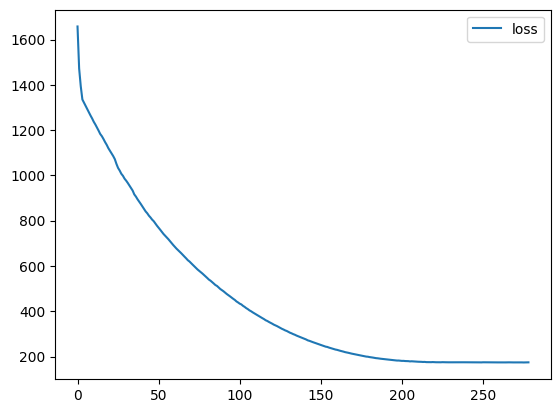

In [152]:
# Show loss:
plt.plot(model.history.history['loss'], label='loss')
# plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


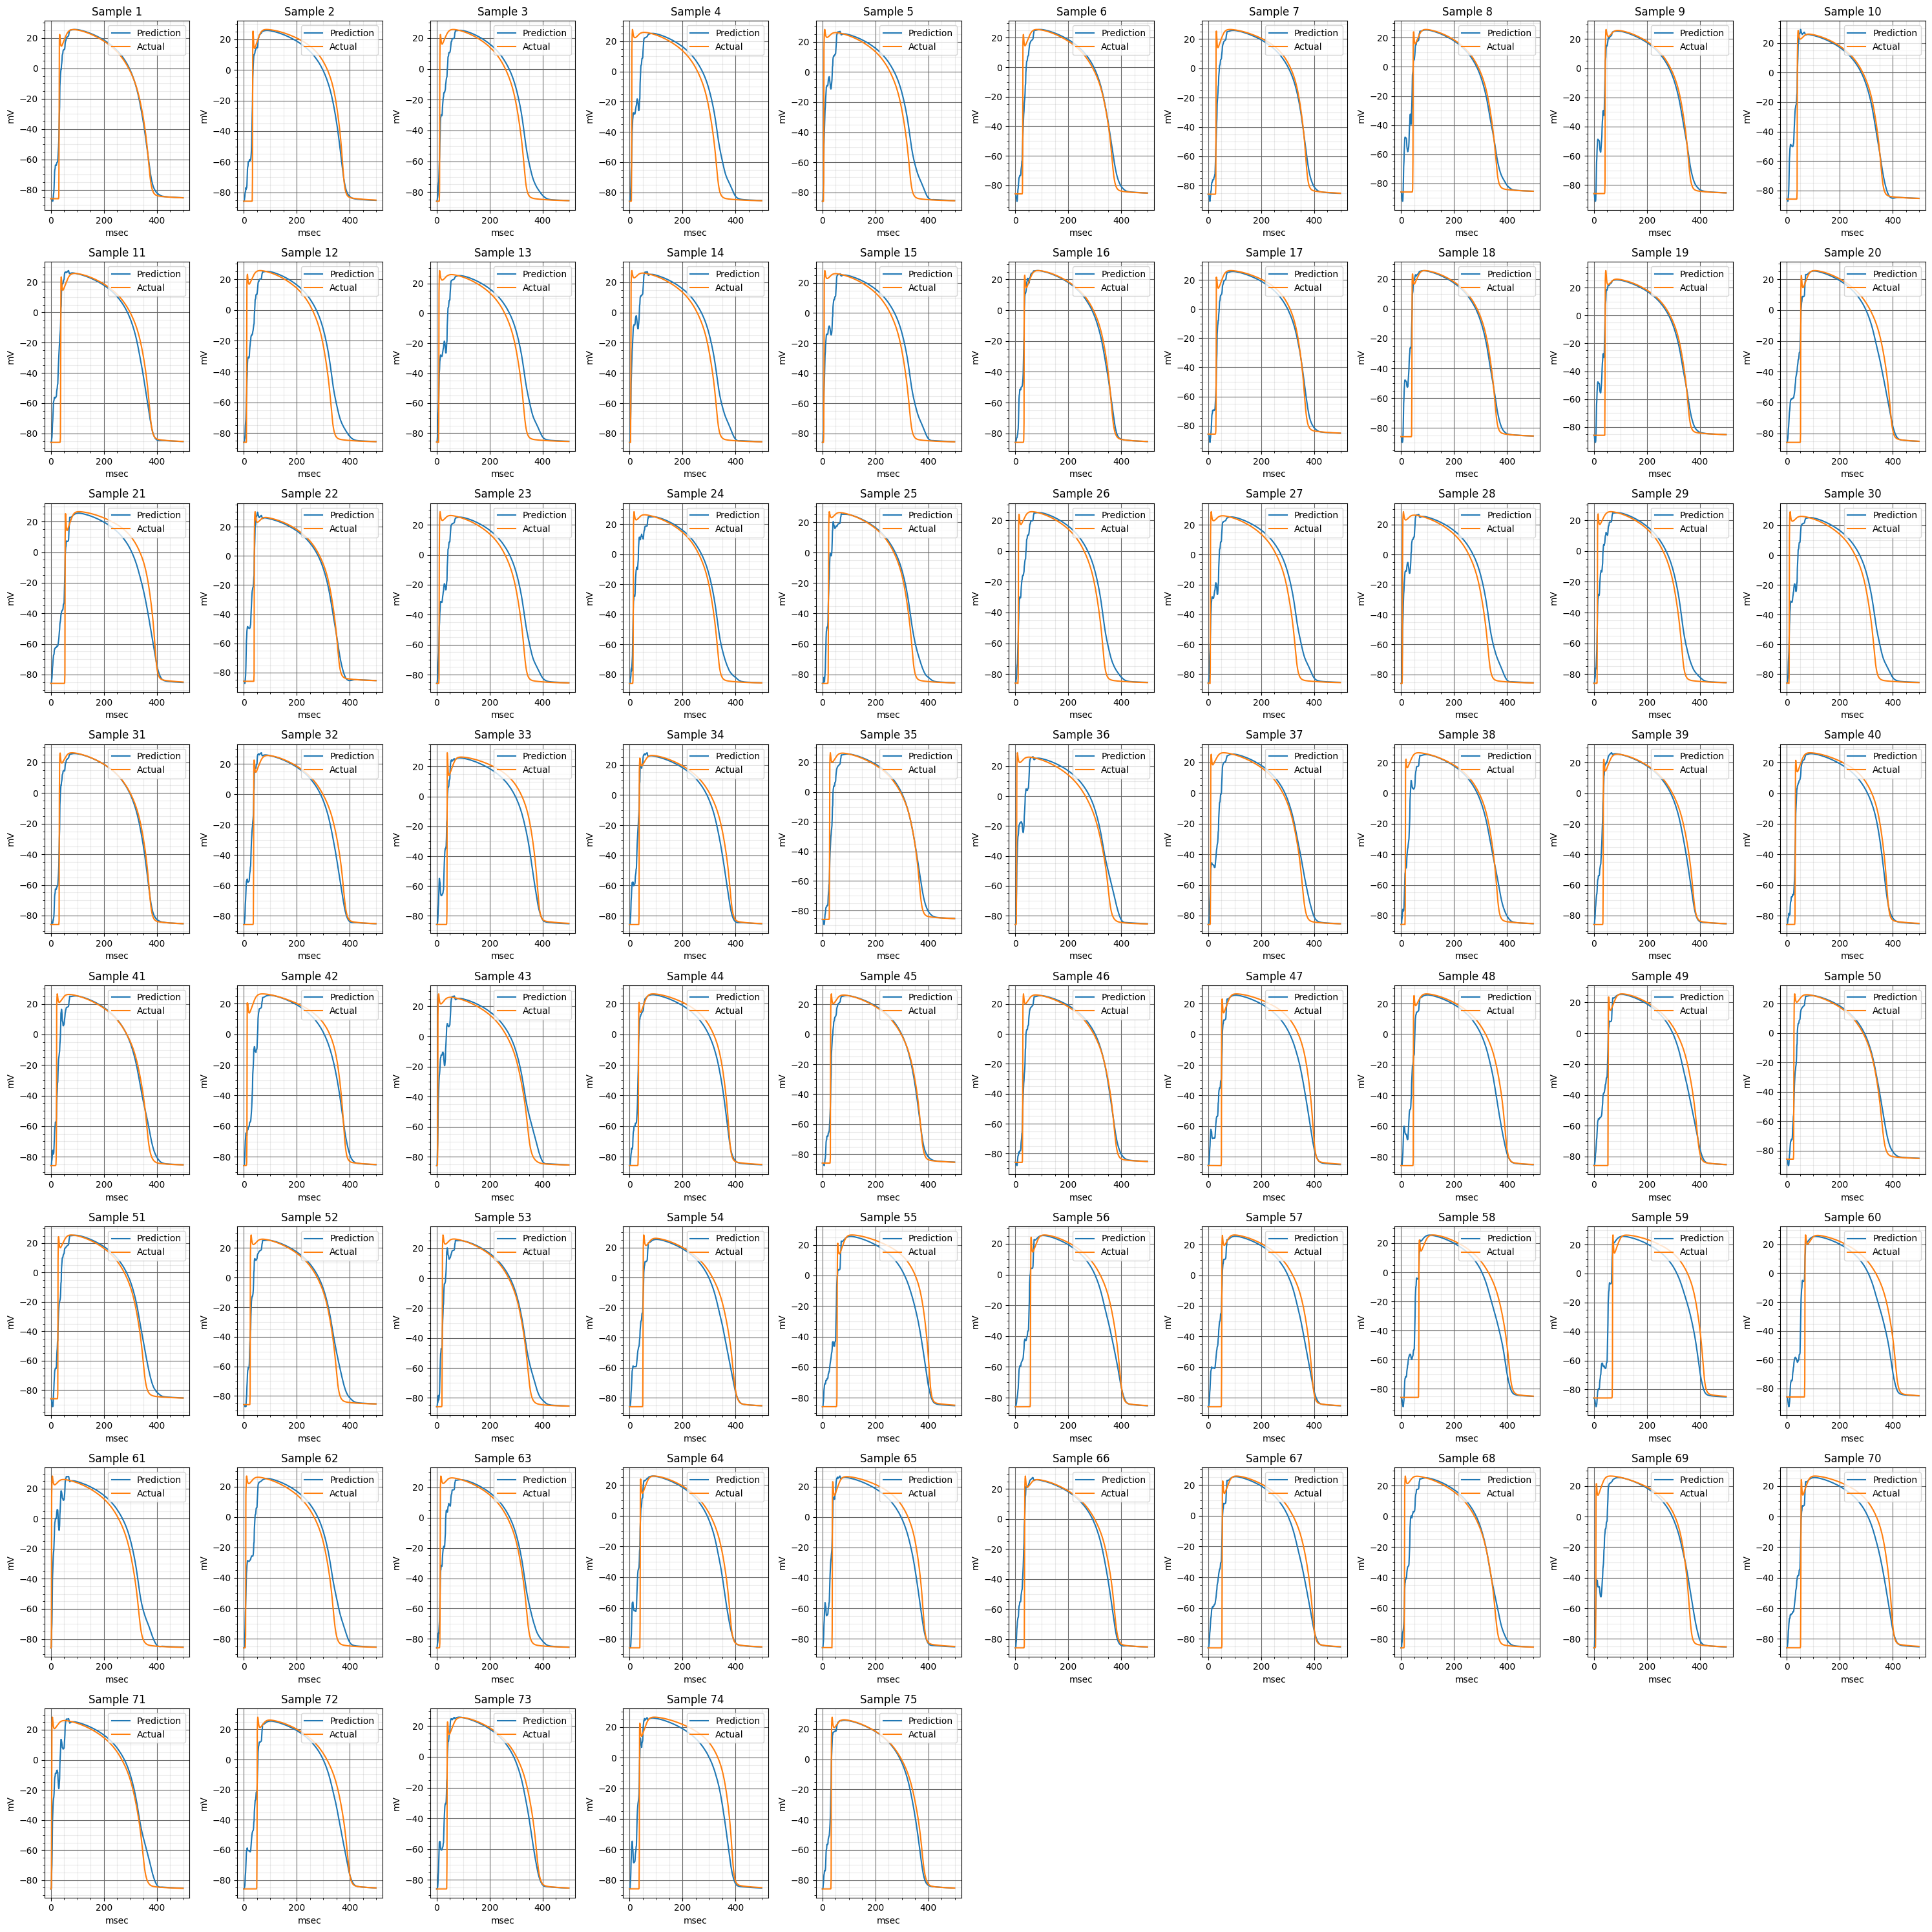

In [175]:
# TO BE CONTINUED PLOT THE GRAPHS AND TEST THE MODEL
predictions = model.predict(X_test)

sample = 213
sample_prediction = predictions[sample]

# Fig Size
plt.figure(figsize=(30, 30))

# Example of file pair

for count, i in enumerate(range(75)):
    plt.subplot(8, 10, count + 1)
    
    # Prediction
    plt.plot(sample_prediction[i])
    # Actual
    plt.plot(y_test[sample][i])

    plt.title(f'Sample {i + 1}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')

    plt.legend(['Prediction', 'Actual'], loc = 'upper right')
plt.tight_layout()
plt.show()
